# Bye Bye DAM
## Import package

In [191]:
## Package
from PIL import Image
from datetime import datetime
import random, os, sys, glob
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
import util
from util.preprocess import *
import shutil

## Setting Parameters

In [182]:
## Read Image and csv
### GBR File
crop = Image.open('/home/sasdemo01/data/gbr/1227/5143b69c01-uts+1_CompSideUnit.bmp')

### Rotate GBR
crop = np.array(crop.rotate(180))
max_y = crop.shape[0]
max_x = crop.shape[1]

### UnitX UnitY 對應位置
mapcsv = pd.read_csv('/home/sasdemo01/data/gbr/0212/S1_5143_T_SR1+DAM_OSP+SOP_01_01_對應位置.csv')

### Original Image Path
#### If Multi_folde=False 
#####-> Path = Single folder (with child folder NG/OK)
#### If Multi_folde=True 
#####-> Path = Mother folder (with multiple child folders)
path = "/home/sasdemo01/data/Unimicron_S1_AVI_Machvision/0212/S1_5143_T_SR1+DAM_OSP+SOP_01_01"


## Set the parameters

### Scale => um/pixel
scale = 4

## X_offset => mm
## Y_offset => mm
X_offset = 0
Y_offset = 0

### Gbr size(1 Unit) => mm
gbrsize = 16.509

### how many images show in example (for chck the rule)
num = 50

## Count the training data
aviimagedir, dirs, files = next(os.walk(path+"/NG"))
NG_count = len(files)
aviimagedir, dirs, files = next(os.walk(path+"/OK"))
OK_count = len(files)

print("OK: ", OK_count)
print("NG: ", NG_count)

Training_Folder="/home/sasdemo01/data/Unimicron_S1_AVI_Machvision/0212/S1_5143_T_SR1+DAM_OSP+SOP_01_01/"

Train_no_DAM="/home/sasdemo01/data/Unimicron_S1_AVI_Machvision/0212/S1_5143_T_SR1+DAM_OSP+SOP_01_01_NODAM/"

OK:  3092
NG:  4323


In [170]:
crop.shape

(5501, 5503)

# DAM area by pixel

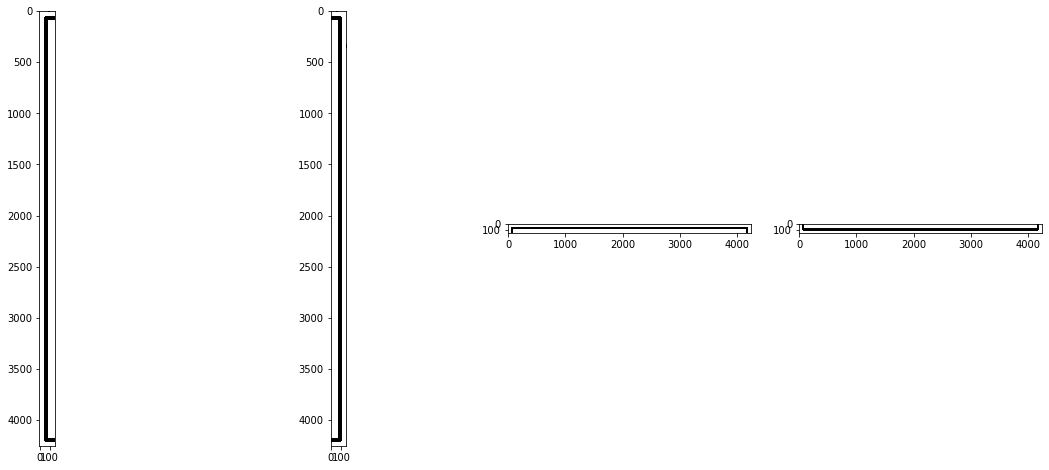

In [171]:
y1_p=620
y2_p=4870
x1_p=630
x2_p=4870
band_p=150

fig=plt.figure(figsize=(20,8))
columns = 4
rows = 1
for i in range(1,columns*rows +1):
    fig.add_subplot(rows, columns, i)
    if i == 1:
        plt.imshow(crop[y1_p:y2_p,x1_p:x1_p+band_p],cmap='gray')
    elif i == 2:
        plt.imshow(crop[y1_p:y2_p,x2_p-band_p:x2_p],cmap='gray')
    elif i == 3:
        plt.imshow(crop[y1_p:y1_p+band_p,x1_p:x2_p],cmap='gray')
    elif i == 4:
        plt.imshow(crop[y2_p-band_p:y2_p,x1_p:x2_p],cmap='gray')
plt.show()

# DAM area by unit (X,Y)

In [172]:
y1_u=y1_p/crop.shape[0]*gbrsize+Y_offset
y2_u=y2_p/crop.shape[0]*gbrsize+Y_offset
x1_u=x1_p/crop.shape[1]*gbrsize+X_offset
x2_u=x2_p/crop.shape[1]*gbrsize+X_offset
band_u=band_p/crop.shape[0]*gbrsize+Y_offset


In [173]:
print(y1_u,y2_u,x1_u,x2_u,band_u)

1.8606762406835122 14.615311761497908 1.89 14.610000000000001 0.45016360661697874


# Find AVI photos near DAM with csv and DAM area by unit(X,Y)

In [174]:
mapcsv['DAM']=''
for i in range(len(mapcsv)):
    if  mapcsv.Unit_Xvalue[i]>=x1_u and mapcsv.Unit_Xvalue[i]<=x1_u+band_u and mapcsv.Unit_Yvalue[i]>=y1_u and mapcsv.Unit_Yvalue[i]<=y2_u:
        mapcsv.DAM[i]="Left"
    elif mapcsv.Unit_Xvalue[i]<=x2_u and mapcsv.Unit_Xvalue[i]>=x2_u-band_u and mapcsv.Unit_Yvalue[i]>=y1_u and mapcsv.Unit_Yvalue[i]<=y2_u:
        mapcsv.DAM[i]="Right"
    elif mapcsv.Unit_Xvalue[i]>=x1_u and mapcsv.Unit_Xvalue[i]<=x2_u and mapcsv.Unit_Yvalue[i]>=y1_u and mapcsv.Unit_Yvalue[i]<=y1_u+band_u:
        mapcsv.DAM[i]="Up"
    elif (mapcsv.Unit_Xvalue[i]>=x1_u and mapcsv.Unit_Xvalue[i]<=x2_u and mapcsv.Unit_Yvalue[i]<=y2_u and mapcsv.Unit_Yvalue[i]>=y2_u-band_u):
        mapcsv.DAM[i]="Low"
 

/home/sasdemo01/anaconda3/envs/py3_6_6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sasdemo01/anaconda3/envs/py3_6_6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sasdemo01/anaconda3/envs/py3_6_6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd fro

In [175]:
mapcsv.head()

,image_path,LotNum,Side,Step_Xvalue,Step_Yvalue,Unit_Xvalue,Unit_Yvalue,Machine,DAM
0,CSPAFI#4_198G2079-02-000_1_NG001_Panel0009_Pro...,198G2079-02-00,C,36.320,87.076,11.456,2.052,CSPAFI#4,Up
1,CSPAFI#4_198G2079-02-000_1_NG001_Panel0009_Pro...,198G2079-02-00,C,23.984,170.820,14.608,14.116,CSPAFI#4,Right
2,CSPAFI#4_198G2079-02-000_1_NG001_Panel0015_Pro...,198G2079-02-00,C,12.640,111.932,3.264,11.420,CSPAFI#4,
3,CSPAFI#4_198G2079-02-000_1_NG001_Panel0015_Pro...,198G2079-02-00,C,24.584,226.464,15.208,7.744,CSPAFI#4,
4,CSPAFI#4_198G2079-02-000_1_NG001_Panel0022_Pro...,198G2079-02-00,C,82.248,168.472,10.888,11.768,CSPAFI#4,


In [176]:
mapcsv_dam = mapcsv[mapcsv['DAM']!='']

In [177]:
mapcsv_dam = mapcsv_dam.reset_index(drop=True)

In [178]:
mapcsv_dam

,image_path,LotNum,Side,Step_Xvalue,Step_Yvalue,Unit_Xvalue,Unit_Yvalue,Machine,DAM
0,CSPAFI#4_198G2079-02-000_1_NG001_Panel0009_Pro...,198G2079-02-00,C,36.320,87.076,11.456,2.052,CSPAFI#4,Up
1,CSPAFI#4_198G2079-02-000_1_NG001_Panel0009_Pro...,198G2079-02-00,C,23.984,170.820,14.608,14.116,CSPAFI#4,Right
2,CSPAFI#4_198G2079-02-000_1_NG003_Panel0009_Pro...,198G2079-02-00,C,53.152,9.584,12.800,2.064,CSPAFI#4,Up
3,CSPAFI#4_198G2079-02-000_1_NG003_Panel0009_Pro...,198G2079-02-00,C,11.320,9.620,1.944,2.100,CSPAFI#4,Left
4,CSPAFI#4_198G2079-02-000_1_NG003_Panel0009_Pro...,198G2079-02-00,C,11.324,182.272,1.948,10.048,CSPAFI#4,Left
...,...,...,...,...,...,...,...,...,...
2683,CSPAFI-C#1_198N2108-01-000_1_NG010_Panel0019_P...,198N2108-01-00,C,31.228,24.948,6.364,1.940,CSPAFI-C#1,Up
2684,CSPAFI-C#1_198N2108-01-000_1_NG011_Panel0004_P...,198N2108-01-00,C,27.000,220.620,2.136,1.900,CSPAFI-C#1,Left
2685,CSPAFI-C#1_198N2108-01-000_1_NG011_Panel0019_P...,198N2108-01-00,C,32.592,9.464,7.728,1.944,CSPAFI-C#1,Up
2686,CSPAFI-C#1_198S2028-02-000_1_NG001_Panel0008_P...,198S2028-02-00,C,38.516,21.848,13.652,14.328,CSPAFI-C#1,Low


In [179]:
mapcsv_dam['Label']='.'

In [180]:
for i in range(len(mapcsv_dam)):
    if os.path.isfile(Training_Folder+"OK/"+mapcsv_dam.image_path[i]):
        mapcsv_dam.Label[i]='OK'
    elif os.path.isfile(Training_Folder+"NG/"+mapcsv_dam.image_path[i]):
        mapcsv_dam.Label[i]='NG'

/home/sasdemo01/anaconda3/envs/py3_6_6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sasdemo01/anaconda3/envs/py3_6_6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [181]:
mapcsv_dam.head()

,image_path,LotNum,Side,Step_Xvalue,Step_Yvalue,Unit_Xvalue,Unit_Yvalue,Machine,DAM,Label
0,CSPAFI#4_198G2079-02-000_1_NG001_Panel0009_Pro...,198G2079-02-00,C,36.320,87.076,11.456,2.052,CSPAFI#4,Up,OK
1,CSPAFI#4_198G2079-02-000_1_NG001_Panel0009_Pro...,198G2079-02-00,C,23.984,170.820,14.608,14.116,CSPAFI#4,Right,OK
2,CSPAFI#4_198G2079-02-000_1_NG003_Panel0009_Pro...,198G2079-02-00,C,53.152,9.584,12.800,2.064,CSPAFI#4,Up,OK
3,CSPAFI#4_198G2079-02-000_1_NG003_Panel0009_Pro...,198G2079-02-00,C,11.320,9.620,1.944,2.100,CSPAFI#4,Left,OK
4,CSPAFI#4_198G2079-02-000_1_NG003_Panel0009_Pro...,198G2079-02-00,C,11.324,182.272,1.948,10.048,CSPAFI#4,Left,OK


# New Training Data without AVI Photos near DAM, 
# AVI list near DAM into csv

In [187]:
if os.path.exists(Train_no_DAM):
    print('done')
else:
    os.mkdir(Train_no_DAM)
    os.mkdir(Train_no_DAM+"NG")
    os.mkdir(Train_no_DAM+"OK")

In [189]:
mapcsv_dam.to_csv(Train_no_DAM+'DAM_LIST.csv', index=False)

In [205]:
NG_DAM=mapcsv_dam[mapcsv_dam['Label']=='NG']
CNT_O=0
CNT=0
for file in glob.glob(os.path.join(Training_Folder+"NG/","*")):
    CNT_O=CNT_O+1
    if file.split("/")[-1] not in NG_DAM.values:
        CNT=CNT+1
        shutil.copy2(file,Train_no_DAM+"NG/")
print(CNT_O,"=>",CNT)

4323 => 3443


In [206]:
OK_DAM=mapcsv_dam[mapcsv_dam['Label']=='OK']
CNT_O=0
CNT=0
for file in glob.glob(os.path.join(Training_Folder+"OK/","*")):
    CNT_O=CNT_O+1
    if file.split("/")[-1] not in OK_DAM.values:
        CNT=CNT+1
        shutil.copy2(file,Train_no_DAM+"OK/")
    
print(CNT_O,"=>",CNT)

3092 => 1284


In [207]:
4323 - 3443+3092 - 1284

2688

In [208]:
len(mapcsv_dam)

2688